# LGS Metadata Statistics and Analysis
### Created by: Steve Robinson

This notebook has been designed to process and display statistis and analysis of galactic center data taken using the laser guide star adaptive optics (LGS-AO) system on the Keck II telescope.  After a new epoch or any additional data becomes available and is downloaded, and the lgs_metadata_compiler.py script has been run to update or repopulate the lgs_metadata.fits file, each cell of this notebook can be run sequentially, top to bottom, to update any and all figures associated with this analysis.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Preamble

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import os
import datetime
from astropy.time import Time, TimezoneInfo
from astropy.table import Table, vstack
from astropy import units as u, constants as c
from datetime import datetime, timezone
import pytz
import time
import glob
import urllib
from astropy.io import fits
from matplotlib import rcParams
from matplotlib.axes import Axes

# Plot style
rcParams["text.usetex"]= True
rcParams["font.family"]= "serif"
rcParams["font.serif"]= []          
rcParams["font.sans-serif"]= []
rcParams["font.monospace"]= []
rcParams["axes.labelsize"]= 24              
rcParams["font.size"]= 24
rcParams["axes.titlesize"]= 24              
rcParams["legend.fontsize"]= 16             
rcParams["xtick.labelsize"]= 20
rcParams["ytick.labelsize"]= 20
rcParams["legend.fontsize"]= 20
rcParams["axes.linewidth"]  = 2 
rcParams["xtick.major.size"]  = 5
rcParams["ytick.major.size"]  = 5 
rcParams["xtick.major.width"]  = 2
rcParams["ytick.major.width"]  = 2
rcParams['figure.figsize'] = (16,10)

In [3]:
%%html
<style>
body {font-family: "Courier", sans-serif;}
</style>

### If you would like to update the metadata.fits file, simply uncomment the lines in the cell below and run it prior to running the rest of the cells in this notebook.

In [4]:
# import lgs_metadata_compiler.py as lmc
# lmc.update()

# Load Datatable, Convert to Pandas df

In [5]:
# file = '/g/lu/data/gc/lgs_metadata.fits'
file = '/Users/stevenrobinson/Desktop/SCHOOL/Research/lgs_metadata.fits'
datatable = Table.read(file, format = 'fits')
df = datatable.to_pandas()

# Statistics

### Histograms of time between measurements

/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


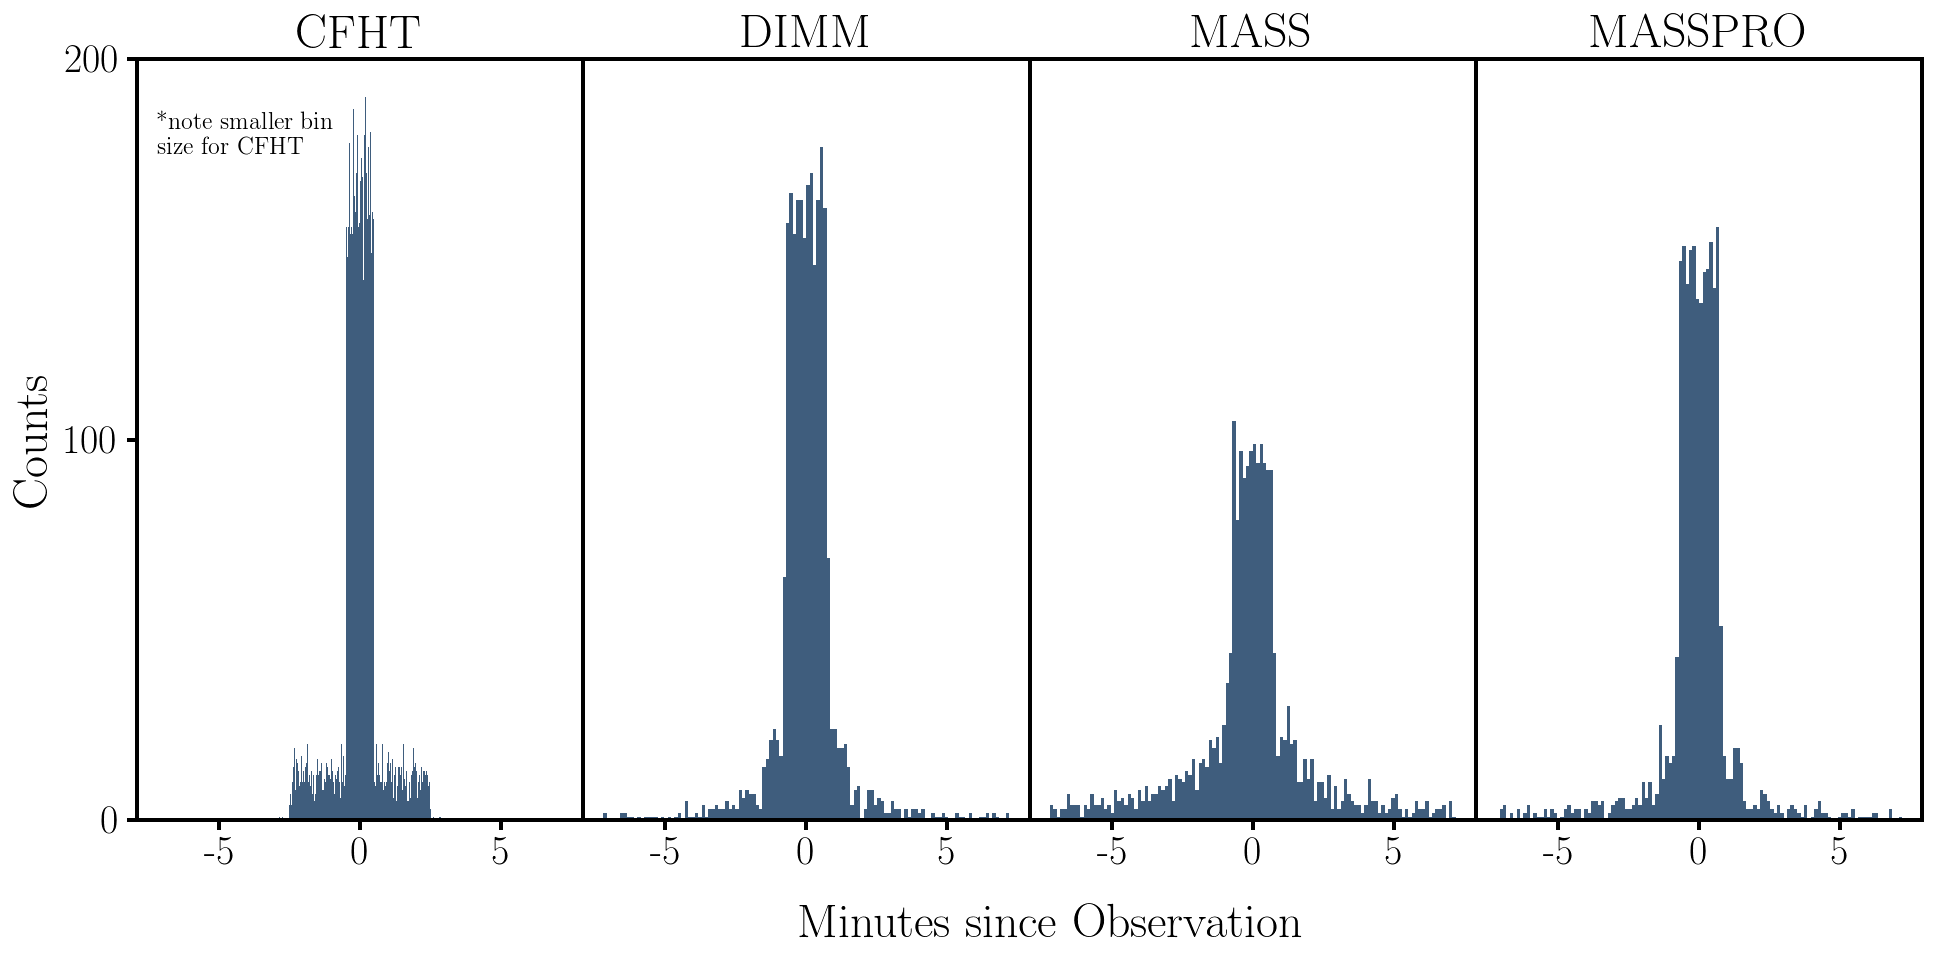

In [6]:
fig, ax = plt.subplots(1, 4, figsize = (16,7))
plt.subplots_adjust(wspace = 0)

color = '#3F5D7D'

x1 = df['cfht_delta_t']
x2 = df['DIMM_delta_t']
x3 = df['MASS_delta_t']
x4 = df['MASSPRO_delta_t']

ax[0].hist(x1, range = (-0.005,0.005), bins = 400, label = 'CFHT', color = color)
ax[0].set_ylabel('Counts')
ax[0].locator_params(axis='y', nbins=2)
ax[0].set_title('CFHT')
ax[0].set_ylim(0,200)
ax[0].text(-0.005,175, '*note smaller bin \n  size for CFHT', fontsize = 12)

ax[1].hist(x2, range = (-0.005,0.005), bins = 120, label = 'DIMM', color = color)
ax[1].set_xlabel('Minutes since Observation')
ax[1].xaxis.set_label_coords(1.05,-0.11)
ax[1].locator_params(axis='y', nbins=2)
ax[1].set_title('DIMM')
ax[1].set_ylim(0,200)
ax[1].set_yticks([])

ax[2].hist(x3, range = (-0.005,0.005), bins = 120, label = 'MASS', color = color)
ax[2].locator_params(axis='y', nbins=2)
ax[2].set_title('MASS')
ax[2].set_ylim(0,200)
ax[2].set_yticks([])

ax[3].hist(x4, range = (-0.005,0.005), bins = 120, label = 'MASSPRO', color = color)
ax[3].locator_params(axis='y', nbins=2)
ax[3].set_title('MASSPRO')
ax[3].set_ylim(0,200)
ax[3].set_yticks([])

for i in range(4):
    ax[i].set_xticks([-0.00347222,0,0.00347222])
    ax[i].set_xticklabels(['-5', '0', '5'])

plt.savefig('delta_t_hists.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Barplots of number of measurements within certain time thresholds

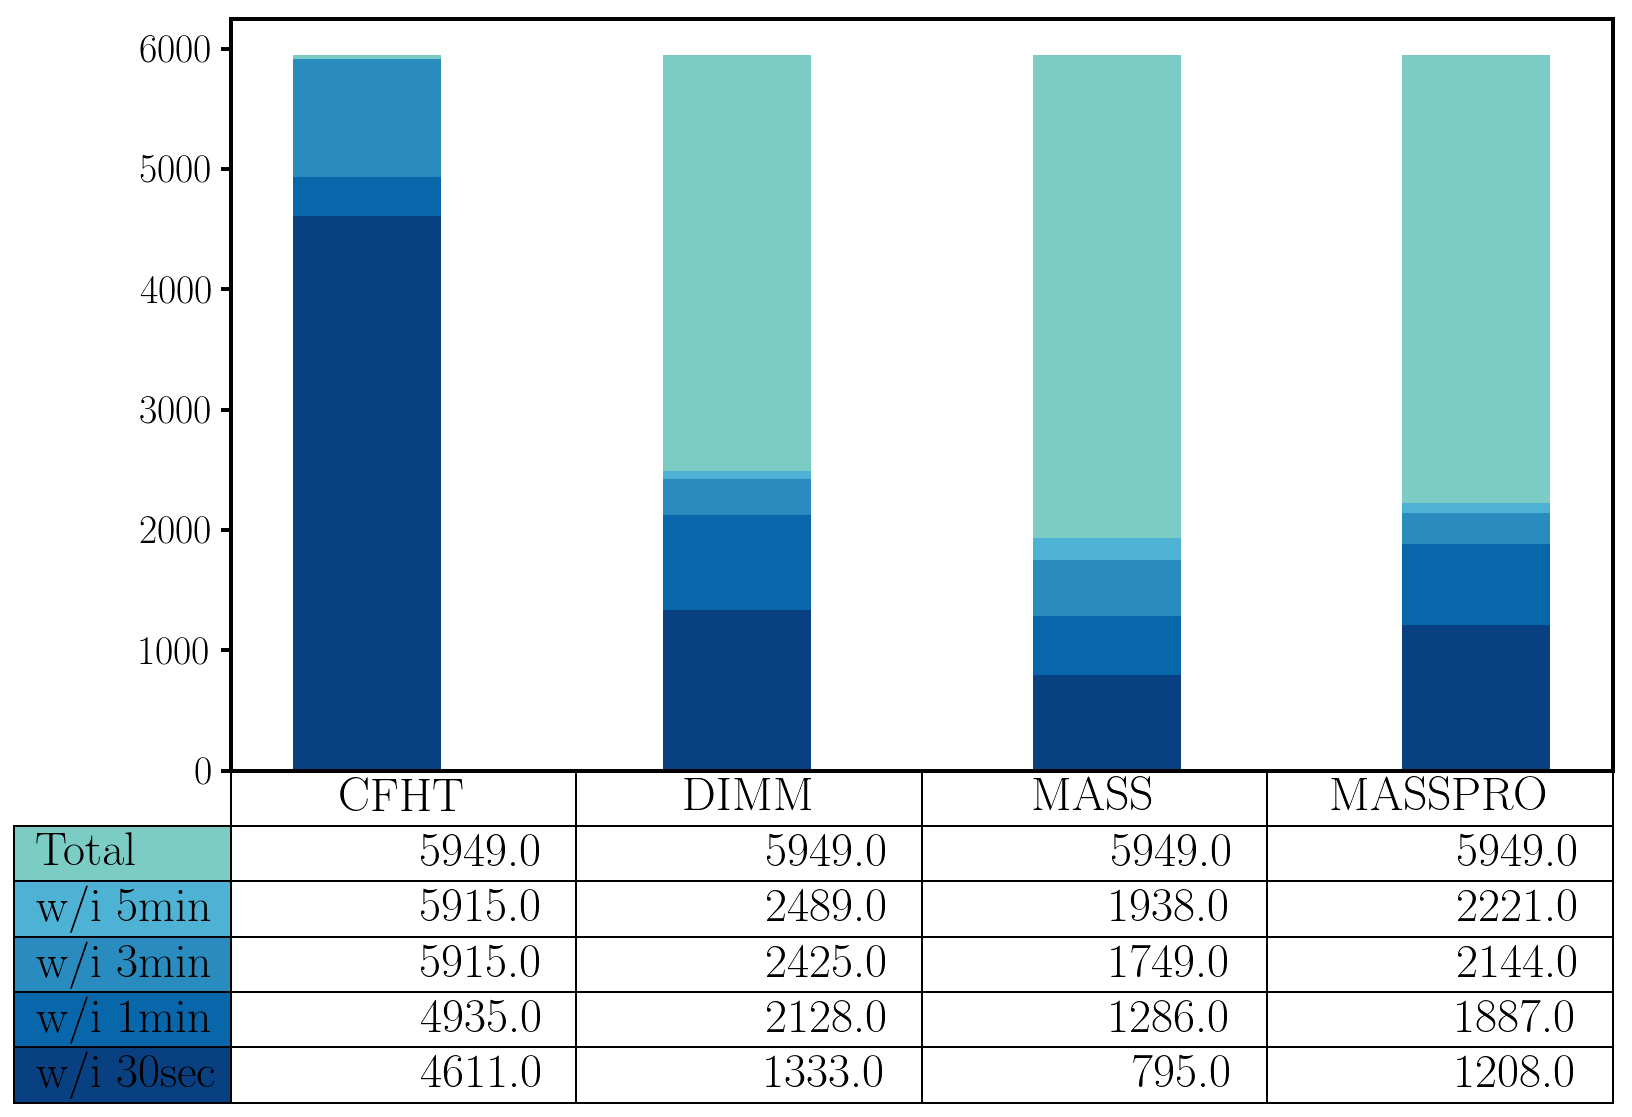

In [7]:
dec_sec = 1 / (24 * 60 * 60)
def less(array, num = 1):
    return sum(np.abs(i) < dec_sec*num for i in array)


plt.figure(figsize = (16,9))

cfht = df['cfht_delta_t']
dimm = df['DIMM_delta_t']
mass = df['MASS_delta_t']
masspro = df['MASSPRO_delta_t']

data = [[len(cfht), len(dimm), len(mass), len(masspro)],
        [less(cfht,300), less(dimm,300), less(mass,300), less(masspro,300)],
        [less(cfht,180), less(dimm,180), less(mass,180), less(masspro,180)],
        [less(cfht,60), less(dimm,60), less(mass,60), less(masspro,60)],
        [less(cfht,30), less(dimm,30), less(mass,30), less(masspro,30)]]

columns = ['CFHT', 'DIMM', 'MASS', 'MASSPRO']
rows = ['Total', 'w/i 5min', 'w/i 3min', 'w/i 1min', 'w/i 30sec',]

colors = plt.cm.GnBu(np.linspace(0.5, 1, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, color=colors[row])
    cell_text.append(['%1.1f' % (x) for x in data[row]])

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text, rowLabels = rows, rowColours = colors, colLabels = columns, loc = 'bottom')
the_table.scale(1,3)
plt.subplots_adjust(left = 0.3, bottom = 0.3)
plt.xticks([])

plt.show()

# Analyis

### Comparing seeing parameters to one another

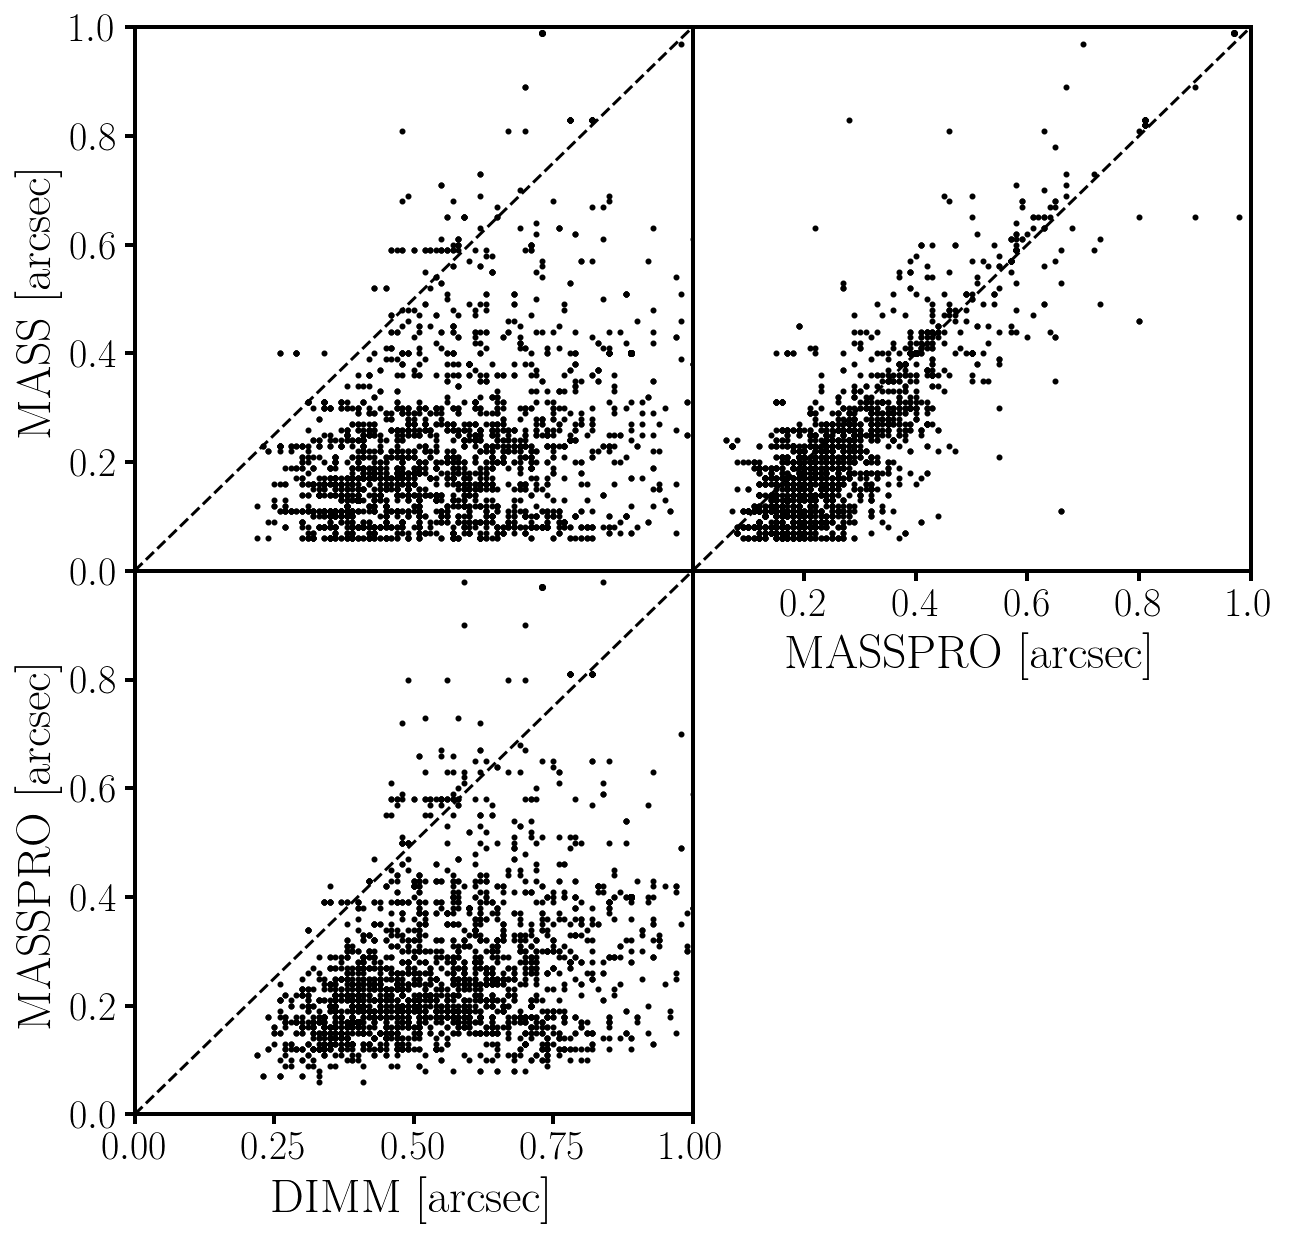

In [8]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
plt.subplots_adjust(hspace = 0, wspace = 0)

model = np.linspace(0,1,100)

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1].axis('off')

# Uncommenting the additional ax.scatter calls below will colorize based on delta t
ax1.scatter(df['DIMM'], df['MASS'], s = 4, c = 'k')
# ax1.scatter(df['DIMM'], df['MASS'], s = 4, c = np.abs(df['DIMM_mjd'] - df['MASS_mjd']), cmap = 'viridis_r')
ax1.plot(model, model, color = 'k', linestyle = '--')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xticks([])
ax1.set_ylabel('MASS [arcsec]')

ax2.scatter(df['MASSPRO'], df['MASS'], s = 4, c = 'k')
# ax2.scatter(df['MASSPRO'], df['MASS'], s = 4, c = np.abs(df['MASSPRO_mjd'] - df['MASS_mjd']), cmap = 'viridis_r')
ax2.plot(model, model, color = 'k', linestyle = '--')
ax2.set_xlabel('MASSPRO [arcsec]')
ax2.set_yticks([])
ax2.set_xticks([0.2,0.4,0.6,0.8,1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

ax3.scatter(df['DIMM'], df['MASSPRO'], s = 4, c = 'k')
# ax3.scatter(df['DIMM'], df['MASSPRO'], s = 4, c = np.abs(df['DIMM_mjd'] - df['MASSPRO_mjd']), cmap = 'viridis_r')
ax3.plot(model, model, color = 'k', linestyle = '--')
ax3.set_ylabel('MASSPRO [arcsec]')
ax3.set_yticks([0,0.2,0.4,0.6,0.8])
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_xlabel('DIMM [arcsec]')

plt.show()

### Seeing vs. FWHM

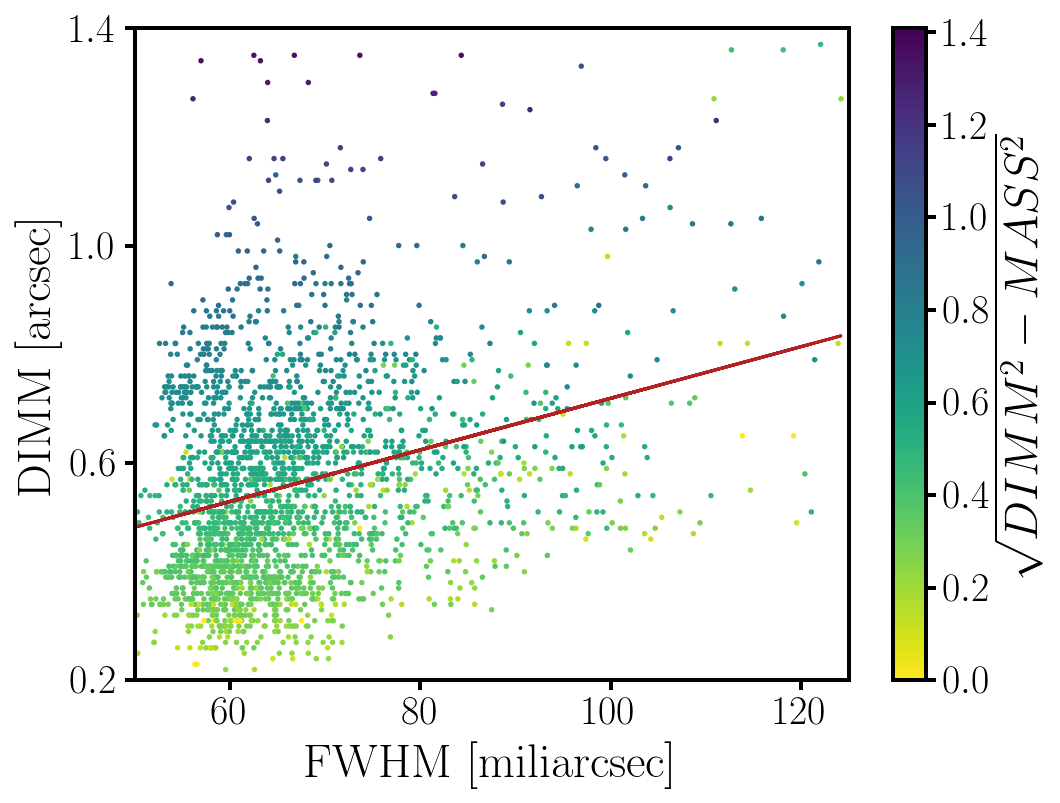

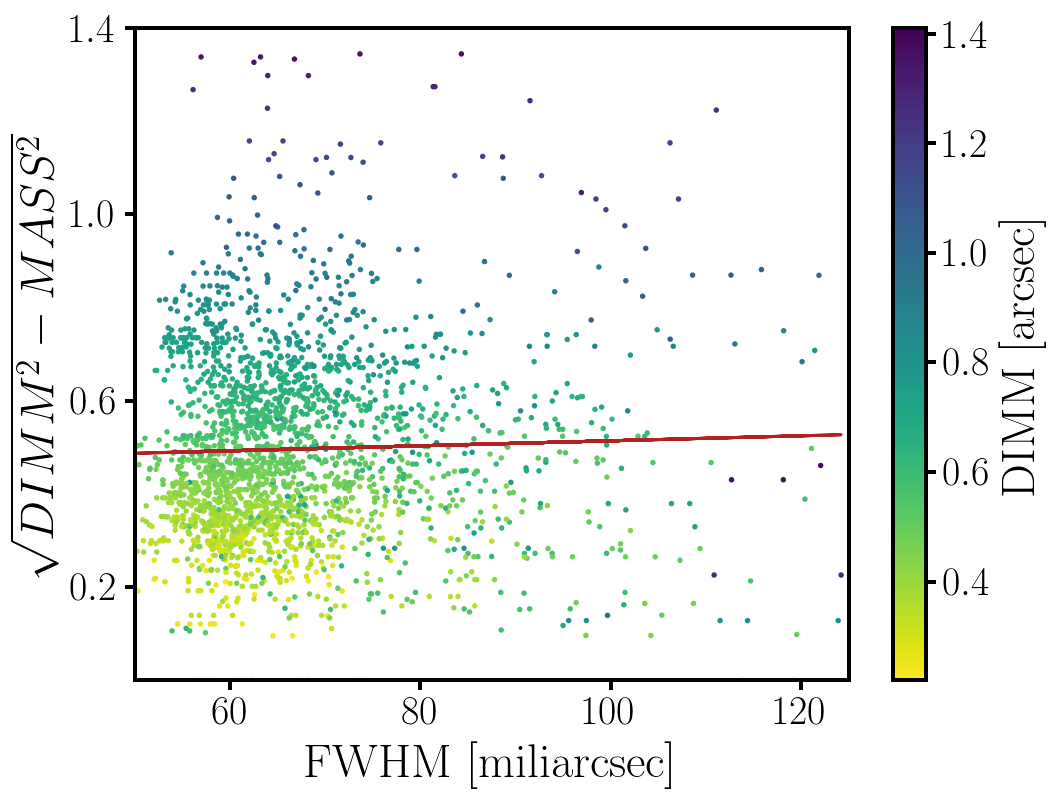

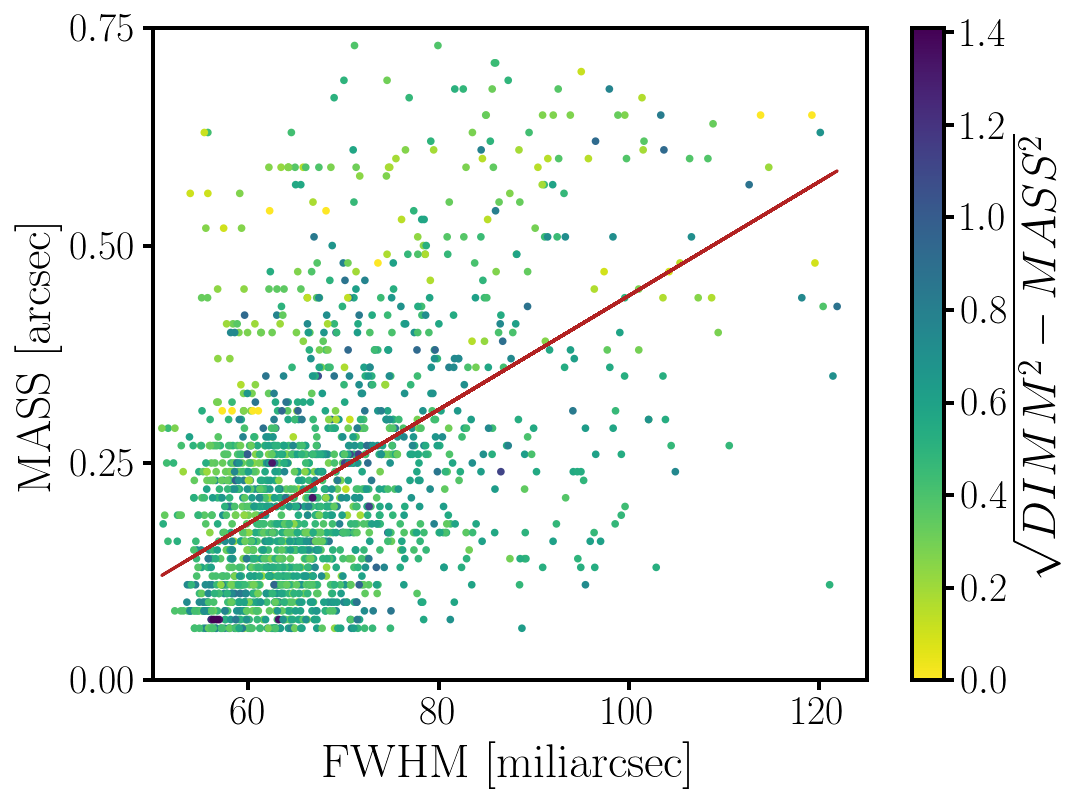

In [9]:
dimm_i = []
mass_i = []
dm_i = []

threshold = 180 # Time in sec before or after image was taken
lower = 50 # Lower bound on FWHM to account for extreme outliers
upper = 125 # Upper bound on FWHM to accound for extreme outliers

for i, row in df.iterrows():
    if np.abs(row['DIMM_delta_t']) < (dec_sec*threshold) and row['fwhm'] > lower and row['fwhm'] < upper:
        dimm_i.append(i)
    if np.abs(row['MASS_delta_t']) < (dec_sec*threshold) and row['fwhm'] > lower and row['fwhm'] < upper:
        mass_i.append(i)
    if np.abs(row['DIMM_delta_t']) < (dec_sec*threshold) and np.abs(row['MASS_delta_t']) < (dec_sec*threshold) and row['fwhm'] > lower and row['fwhm'] < upper:
        dm_i.append(i)

x = df['fwhm']
y1 = df['DIMM']
y2 = df['MASS']
y3 = np.sqrt(np.abs(y1**2 - y2**2))

b1, m1 = np.polynomial.polynomial.polyfit(x[dimm_i], y1[dimm_i], deg=1, rcond=None, full=False)
fit1 = [m1 * x + b1 for x in x[dimm_i]]

b3, m3 = np.polynomial.polynomial.polyfit(x[dimm_i], y3[dimm_i], deg=1, rcond=None, full=False)
fit3 = [m3 * x + b3 for x in x[dimm_i]]

b2, m2 = np.polynomial.polynomial.polyfit(x[mass_i], y2[mass_i], deg=1, rcond=None, full=False)
fit2 = [m2 * x + b2 for x in x[mass_i]]

plt.figure(figsize = (8,6))
plt.scatter(x[dimm_i], y1[dimm_i], s = 3, c = y3[dimm_i], cmap = 'viridis_r')
plt.plot(x[dimm_i],fit1, color = 'firebrick')
plt.ylabel('DIMM [arcsec]')
plt.xlabel('FWHM [miliarcsec]')
plt.ylim(0.2,1.4)
plt.xlim(50,125)
plt.yticks([0.2,0.6,1,1.4])
cbar = plt.colorbar()
cbar.set_label('^\r $ \sqrt[]{DIMM^2 - MASS^2} $')
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(x[dimm_i], y3[dimm_i], s = 3, c = y1[dimm_i], cmap = 'viridis_r')
plt.plot(x[dimm_i],fit3, color = 'firebrick')
plt.ylabel('^\r $ \sqrt[]{DIMM^2 - MASS^2} $')
plt.xlabel('FWHM [miliarcsec]')
plt.ylim(0,1.4)
plt.xlim(50,125)
plt.yticks([0.2,0.6,1,1.4])
cbar = plt.colorbar()
cbar.set_label('DIMM [arcsec]')
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(x[mass_i], y2[mass_i], s = 8, c = y3[mass_i], cmap = 'viridis_r')
plt.plot(x[mass_i],fit2, color = 'firebrick')
plt.ylabel('MASS [arcsec]')
plt.xlabel('FWHM [miliarcsec]')
plt.xlim(50,125)
plt.ylim(0.05,0.75)
plt.yticks([0,.25,.5,.75])
cbar2 = plt.colorbar()
cbar2.set_label('^\r $ \sqrt[]{DIMM^2 - MASS^2} $')
plt.show()

### Strehl, FWHM vs. various other parameters

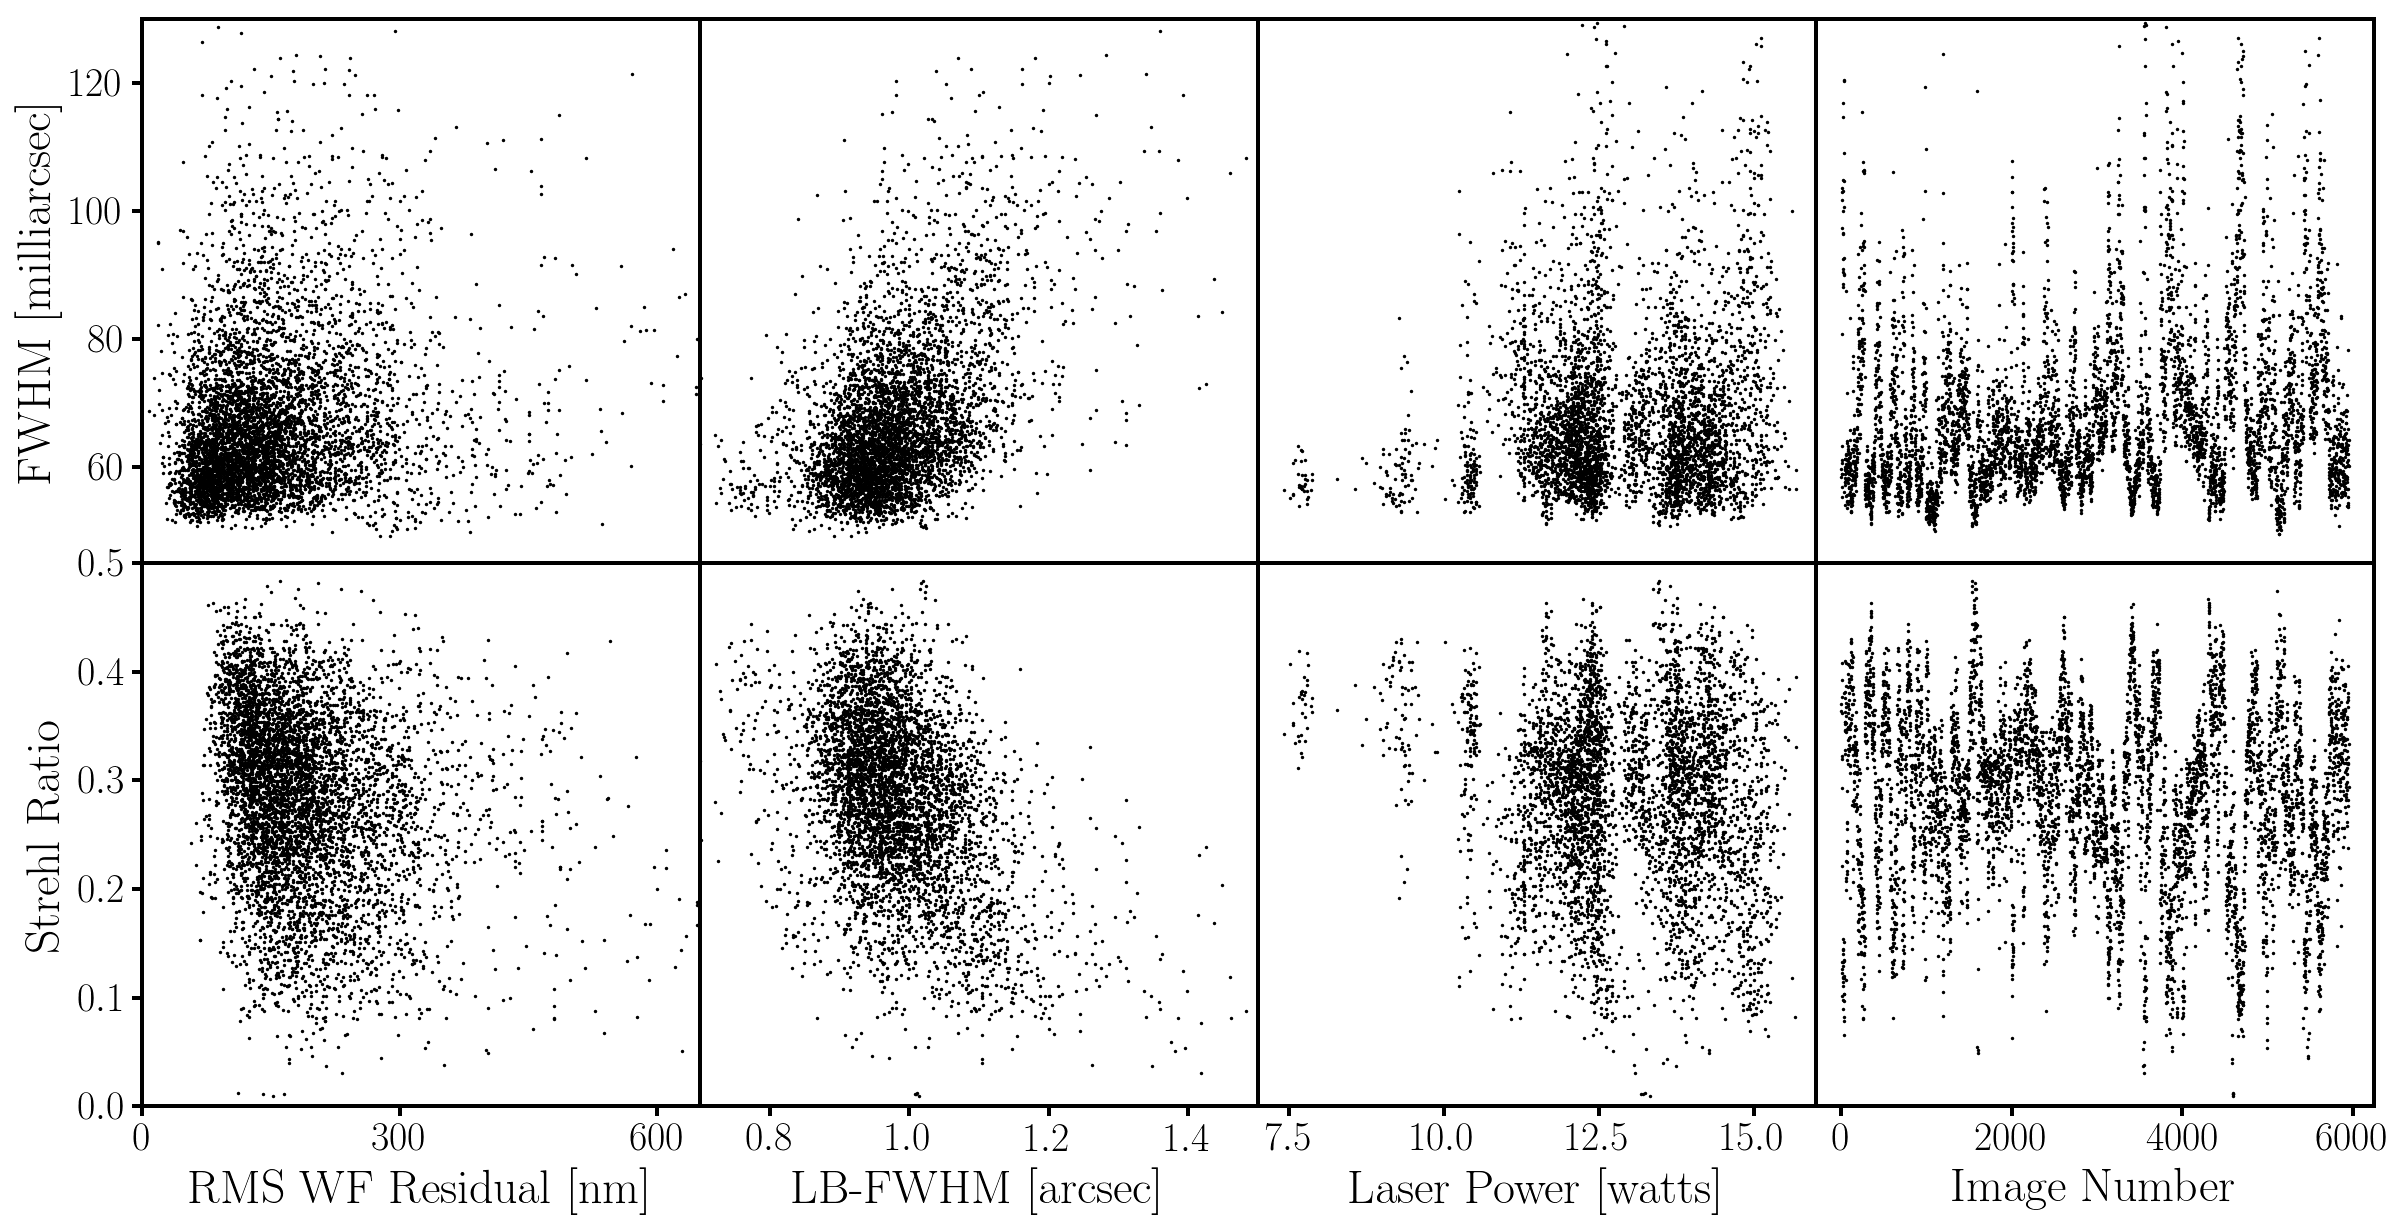

In [10]:
ii = []
jj = []

for i, row in df.iterrows():
    if row['fwhm'] > 50 and row['fwhm'] < 125 and row['lgrmswf'] > 40 and row['lgrmswf'] < 650:
        ii.append(i)
    if row['fwhm'] > 50 and row['fwhm'] < 125 and row['aolbfwhm'] > 0.7 and row['aolbfwhm'] < 1.4:
        jj.append(i)

fig, ax = plt.subplots(2,4, figsize = (20,10))
plt.subplots_adjust(hspace = 0, wspace = 0)
        
ax1 = ax[0,0]
ax2 = ax[1,0]
ax3 = ax[0,1]
ax4 = ax[1,1]
ax5 = ax[0,2]
ax6 = ax[1,2]
ax7 = ax[0,3]
ax8 = ax[1,3]

x1 = df['lgrmswf']
x2 = df['aolbfwhm']
y1 = df['fwhm']
y2 = df['strehl']

ax1.scatter(x1,y1, s = 0.5, c = 'k')
ax1.set_xlim(50,650)
ax1.set_xticks([])
ax1.set_ylim(45,130)
ax1.set_ylabel('FWHM [milliarcsec]')

ax2.scatter(x1,y2, s = 0.5, c = 'k')
ax2.set_ylim(0,0.5)
ax2.set_xlim(50,650)
ax2.set_xticks([0,300,600])
ax2.set_ylabel('Strehl Ratio')
ax2.set_xlabel('RMS WF Residual [nm]')

ax3.scatter(x2,y1, s = 0.5, c = 'k')
ax3.set_xlim(0.7,1.5)
ax3.set_ylim(45,130)
ax3.set_xticks([])
ax3.set_yticks([])

ax4.scatter(x2,y2, s = 0.5, c = 'k')
ax4.set_ylim(0,0.5)
ax4.set_xlim(0.7,1.5)
ax4.set_yticks([])
ax4.set_xlabel('LB-FWHM [arcsec]')

ax5.scatter(df['lsamppwr'],y1, s = 0.5, c = 'k')
ax5.set_ylim(45,125)
ax5.set_xlim(7,16)
ax5.set_xticks([])
ax5.set_yticks([])

ax6.scatter(df['lsamppwr'],y2, s = 0.5, c = 'k')
ax6.set_ylim(0,0.5)
ax6.set_xlim(7,16)
ax6.set_yticks([])
ax6.set_xlabel('Laser Power [watts]')

ax7.scatter(range(len(df)),y1, s = 0.5, c = 'k')
ax7.set_ylim(45,125)
ax7.set_xticks([])
ax7.set_yticks([])

ax8.scatter(range(len(df)),y2, s = 0.5, c = 'k')
ax8.set_ylim(0,0.5)
ax8.set_yticks([])
ax8.set_xlabel('Image Number')

plt.savefig('panel.pdf', format = 'pdf', transparent = True)
plt.show()

### Testing the Maréchal approximation:

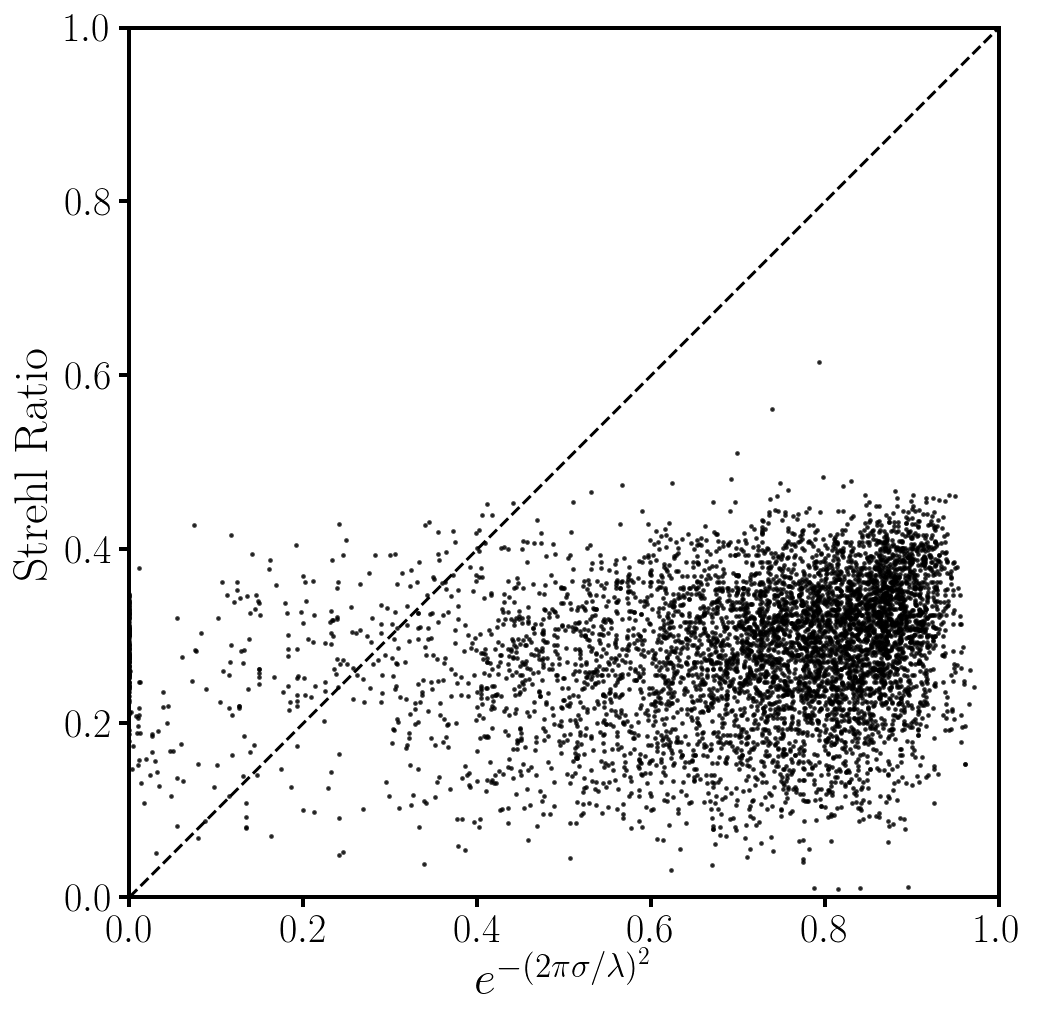

In [12]:
pi = np.pi
wavelength = 2124.5 * u.nm
df['sigma'] = df['lgrmswf'] * 2 * pi / wavelength

lim = len(df)
x = np.exp(-(df['sigma'][:lim]**2))
y = df['strehl'][:lim]

model = np.linspace(0,1,100)

plt.figure(figsize = (8,8))
plt.scatter(x, y, c = 'k', s = 2, alpha = 0.7)
plt.plot(model,model, c = 'k', linestyle = '--')
plt.axis('scaled')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('\r $e^{-(2 \pi \sigma / \lambda)^2}$')
plt.ylabel('Strehl Ratio')
plt.show()